In [29]:
from model import *
from train_test_split import *
from predictionsGraph import *
from data_set import *
from torch.utils.data import DataLoader
from scipy.stats import spearmanr

In [30]:
seq_len = 30 #ovdje treba biti ista vrijednost kao kad se treniralo
batch_size = 1 #
hidden_dim = 16
hidden_dim2 = 128
attention = True
train_data, val_data, test_data = load_data('real_for_all_podaci.csv', 'lognormalize', 'PRTR') 
input_dim = train_data.shape[1]
train_dataset = Dataset(train_data, seq_len, 'PRTR')
test_dataset = Dataset(test_data, seq_len,'PRTR')
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)
train_loader = DataLoader(train_dataset, shuffle=False, batch_size=batch_size)
model = Net(input_dim,  hidden_dim = hidden_dim, hidden_dim2 = hidden_dim2,  seq_len=seq_len, attention=attention)

In [31]:
data = pd.read_csv('real_for_all_podaci.csv')
data = data[['PRTR', 'GOD', 'LOK']]
trainvalid_dataset_pom, test_dataset_pom = train_test_split(data, 'PRTR', locations = ['NS'], test_years=[2015,2016])
train_dataset_pom, valid_dataset_pom = train_test_split(trainvalid_dataset_pom, 'PRTR', locations = ['NS'], test_years = [2013,2014])
mean_PRTR = train_dataset_pom['PRTR'].mean()
def returnToStartingValues(value, mean):
    return (np.e**value-1)*mean

In [32]:
path_to_model = 'models/PRTR/batch_size_128-lr_0.004482174003270632-hidd_dim_16-att_True_best.weights'
model.load_state_dict(torch.load(path_to_model))
model.eval()

Net(
  (lstm): LSTM(7, 16, batch_first=True)
  (fc1): Linear(in_features=16, out_features=128, bias=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (attention): Attention(
    (v): Linear(in_features=30, out_features=1, bias=True)
  )
)

In [33]:
realValues = []
predictedValues = []
#h = model.lstm.weight_ih_l0
#h = model.init_hidden(batch_size)

for (inputs, labels) in test_loader:
    inputs, labels = inputs, labels 
    #print(inputs.shape)
    output = model(inputs)#, h)
    realValues.append(returnToStartingValues(labels.item(),mean_PRTR))
    predictedValues.append(returnToStartingValues(output.item(),mean_PRTR))
    
#predictionsGraph([realValues, predictedValues],['stvarna', 'LSTM'])
#predictionsGraphScatter([realValues, predictedValues], ['stvarna', 'LSTM'])

#loss_fn = nn.MSELoss(reduction='sum')
#loss = loss_fn(torch.FloatTensor(realValues), torch.FloatTensor(predictedValues))
#print(loss)

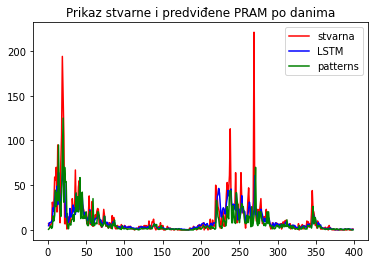

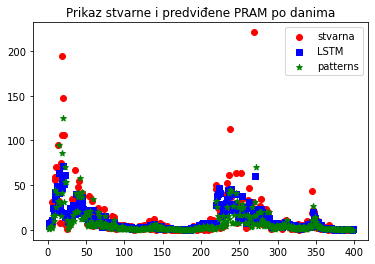

loss LSTM: tensor(17.0091) loss pattern: tensor(17.8846)


In [34]:
podaciZaCrtanje = pd.read_csv('trave_NoviSad_patternPredictions.csv')
podaciZaCrtanje = podaciZaCrtanje.sort_values(by=['DAT'])
#print(podaciZaCrtanje)
staraPredvidjenaVrijednost = []
for i in range(len(podaciZaCrtanje)):
    staraPredvidjenaVrijednost.append(podaciZaCrtanje.iloc[i].predvidjenaVrijednost)
staraPredvidjenaVrijednost = staraPredvidjenaVrijednost[seq_len:] #jer za prva 3 dana LSTM ne predvidja (tako su napravljeni podaci)
predictionsGraph([realValues, predictedValues, staraPredvidjenaVrijednost], ['stvarna', 'LSTM', 'patterns'])
predictionsGraphScatter([realValues, predictedValues, staraPredvidjenaVrijednost], ['stvarna', 'LSTM', 'patterns'])

loss_fn = nn.MSELoss(reduction='mean')
loss1 = np.sqrt(loss_fn(torch.FloatTensor(realValues), torch.FloatTensor(predictedValues)))
loss2 = np.sqrt(loss_fn(torch.FloatTensor(realValues), torch.FloatTensor(staraPredvidjenaVrijednost)))
print('loss LSTM:',loss1,'loss pattern:',loss2)

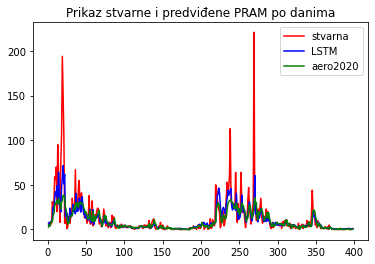

loss LSTM: tensor(17.0091) loss aero2020: tensor(18.1666)


In [35]:
aero2020_PRTR = pd.read_csv('aero2020_predictions/test_prtr_lag=3_pred.csv', header = 0)
aero2020_PRTR = aero2020_PRTR.iloc[seq_len-1:,:].reset_index()
aero2020_PRTR_predicted = list(map(lambda x: float(x), list(aero2020_PRTR['Neural Network'])))
aero2020_PRTR_predicted = list(map(lambda x: returnToStartingValues(x,mean_PRTR),aero2020_PRTR_predicted))
predictionsGraph([realValues, predictedValues, aero2020_PRTR_predicted], ['stvarna', 'LSTM', 'aero2020'])
loss1 = np.sqrt(loss_fn(torch.FloatTensor(realValues), torch.FloatTensor(predictedValues)))
loss2 = np.sqrt(loss_fn(torch.FloatTensor(realValues), torch.FloatTensor(aero2020_PRTR_predicted)))
print('loss LSTM:',loss1,'loss aero2020:',loss2)

In [36]:
spearman_LSTM = spearmanr(realValues, predictedValues)
spearman_pattern = spearmanr(realValues, staraPredvidjenaVrijednost)
spearman_aero2020 = spearmanr(realValues, aero2020_PRTR_predicted)

print(f"Spearman's coefficient: \n\t LSTM = {spearman_LSTM} \n \t pattern = {spearman_pattern}, \n \t aero2020 = {spearman_aero2020}")

Spearman's coefficient: 
	 LSTM = SpearmanrResult(correlation=0.8471633936852146, pvalue=8.308016317850437e-111) 
 	 pattern = SpearmanrResult(correlation=0.7760121126590882, pvalue=2.798867735318692e-81), 
 	 aero2020 = SpearmanrResult(correlation=0.8521097699658501, pvalue=2.0794145863935364e-113)
